# vision

> 对于图片/视频的处理

In [ ]:
#| default_exp vision

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from wcpdtoolbox.imports import *

In [ ]:
path = untar_data(url=URLs.PETS)
imgs = get_image_files(path/'images')
vid_path = '/ailearn/dataset/video/own/20230127_032459.mp4'

## xyzimg

处理xyz色彩空间的图片

In [ ]:
#| export
def open_img_cv2(path:str): return cv2.imread(str(path))

使用cv2打开图片

In [ ]:
#| export
def img2xyz(img:np.array):
    img = img.astype(np.uint16)*255
    img = cv2.cvtColor(img, cv2.COLOR_BGR2XYZ).astype(np.float32)/(65535)
    img = torch.from_numpy(img)
    img = torch.unsqueeze(img, 0).permute(0, 3, 1, 2) if img.dim() == 3 else img.permute(0, 3, 1, 2)
    return img

转换为xyz色彩空间并转换为float32

In [ ]:
#| export
def xyz2img(img:Tensor):
    img = img.permute(0, 2, 3, 1).cpu().detach().numpy()*255
    img = np.stack(cv2.cvtColor(*img, cv2.COLOR_XYZ2RGB).astype(np.uint8))
    return img

转换为rgb色彩空间并转换为uint8

In [ ]:
#| export
def open_img_xyz(path): return img2xyz(open_img_cv2(path))

使用xyz色彩空间打开图片

In [ ]:
img = open_img_xyz(imgs[0])

In [ ]:
xyz2img(img).shape,img.shape

((400, 600, 3), torch.Size([1, 3, 400, 600]))

In [ ]:
#| export
def show_img(img:np.array):
    l = L()
    if len(img.shape) == 3:
        l.append(PILImage.create(img))
    else:
        for i in img:
            l.append(PILImage.create(i))
    return l

打开一个rgb图片(PIL)

In [ ]:
#| export
def show_img_xyz(img:Tensor):
    img = xyz2img(img)
    l = show_img(img)
    return l

打开一组(n\*c\*x\*y)xyz图片,返回一个列表

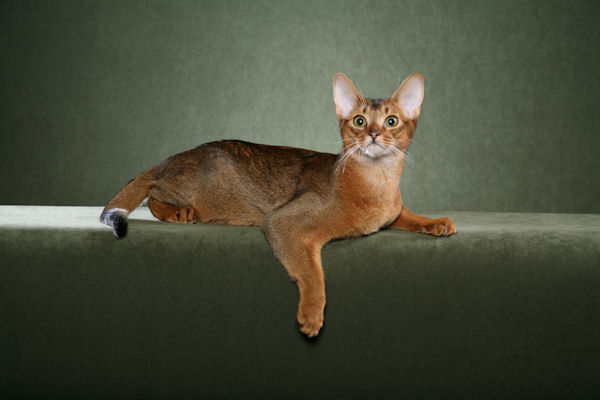

In [ ]:
show_img_xyz(img)[0]

In [ ]:
#| export
def img_xyz_pipe(): return Transform(enc=open_img_xyz, dec=show_img_xyz)

显示与打开图片的Transform形式

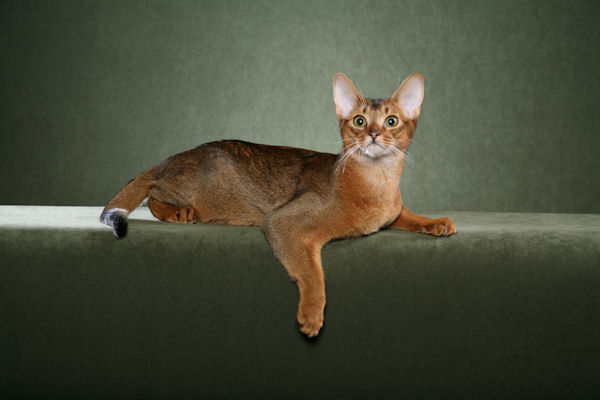

In [ ]:
imgxyz = img_xyz_pipe()
imgxyz.decode(imgxyz(imgs[0]))[0]

In [ ]:
imgxyz.decode(imgxyz(imgs[0]))

(#1) [PILImage mode=RGB size=600x400]

## pickimg
对图片进行拾取

In [ ]:
#| export
class PickImg(nn.Module):
    def __init__(self, device="cpu", return_grid=False,):
        super().__init__()
        self.device = device
        self.mat_val = torch.tensor([[0, 1, 1, 0, 0.]]).to(device)
        self.to(device)
        self.return_grid = return_grid
        # self.comb_grid = comb_grid

使用F.grid_sample拾取图片的类

In [ ]:
#| export
@patch()
def get_grid_mat(self:PickImg, val:Tensor=None):
    if val == None:
        val = self.mat_val
    s0 = torch.stack([torch.cos(val[:, 0])/val[:, 1], -torch.sin(val[:, 0])/val[:, 1], val[:, 3]])
    s1 = torch.stack([torch.sin(val[:, 0])/val[:, 2], torch.cos(val[:, 0])/val[:, 2], val[:, 4]])
    s = torch.stack([s0, s1]).permute(2, 0, 1).reshape(-1, 2, 3)
    return s.to(self.device)

zeta=0, mult_x=1, mult_y=1, offset_x=0, offset_y=0

使用一组数据获取变换矩阵

In [ ]:
#| export
@patch()
def create_grid(self: PickImg, mats: Tensor, pick_size: list):
    pick_size = torch.Size(pick_size)
    return F.affine_grid(mats, pick_size).to(self.device)

使用矩阵和picksize获取grid

mats.shape[0]需要与pick_size[0]相等

In [ ]:
#| export
@patch()
def create_grid_by_matval(self: PickImg, pick_size, matval: Tensor = None):
    # use mat val to create grid
    mats = self.get_grid_mat(matval)
    return self.create_grid(mats, pick_size).to(self.device)

zeta=0, mult_x=1, mult_y=1, offset_x=0, offset_y=0

使用一组数据和picksize获取grid

In [ ]:
#| export
@patch()
def create_basic_grid(self: PickImg, img: Tensor, pick_size: list):
    mat = self.get_grid_mat().repeat(img.shape[0], 1, 1).to(self.device)
    basic_grid = self.create_grid(mat, pick_size)
    return basic_grid.to(self.device)

使用`img`和`pick_size`获取一个基本的grid,相当于缩放到`pick_size`

In [ ]:
#| export
@patch()
def create_img_with_grid(self:PickImg, img): return torch.hstack((self.create_basic_grid(img, img.size()).permute(0,3,1,2),img))

为`img`产生位置编码

In [ ]:
#| export
@patch()
def forward(self:PickImg,
            img:Tensor, # 4d img
            pick_size:list=[32,32], # like [32, 32]
            grid=None, # Size([n,x,y,c])
            matval=None,  # like [[0,0,0,0,0]]
           ):
    
    if grid != None:
        pick_size = [grid.shape[0],img.shape[1]] + pick_size
        img = img.expand(grid.shape[0], *img.shape[1:])
        img = F.grid_sample(img, grid, padding_mode="reflection").to(self.device)
        return (img, grid) if self.return_grid else img
    
    if matval != None:
        pick_size = [matval.shape[0],img.shape[1]] + pick_size
        img = img.expand(matval.shape[0], *img.shape[1:])
        matval = tensor(matval).float()
        grid = self.create_grid_by_matval(pick_size, matval)
        img = F.grid_sample(img, grid, padding_mode="reflection").to(self.device)
        return (img, grid) if self.return_grid else img
    
    pick_size = [img.shape[0],img.shape[1]] + pick_size
    grid = self.create_basic_grid(img, pick_size)
    img = F.grid_sample(img, grid, padding_mode="reflection").to(self.device)
    return (img, grid) if self.return_grid else img

使用F.grid_sample拾取图片

In [ ]:
pick = PickImg()

缩放至尺寸

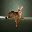

In [ ]:
picked_img = pick(img)
show_img_xyz(picked_img)[0]

使用matval:zeta=0, mult_x=1, mult_y=1, offset_x=0, offset_y=0

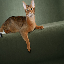

In [ ]:
picked_img = pick(img, [64,64], matval=pick.mat_val+0.2)
show_img_xyz(picked_img)[0]

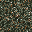

In [ ]:
picked_img = pick(img, grid=torch.randn(1,32,32,2))
show_img_xyz(picked_img)[0]

## Video

In [ ]:
#| export
class VideoGet:
    def __init__(self, 
                 src, # 视频路径,可以为本地地址或网络摄像头
                 queue # 队列
                ):
        
        self.stream = cv2.VideoCapture(src)
        self.grabbed, self.frame = self.stream.read()
        self.stopped = False
        self.q = queue
        
        frame = self.frame
        self.q.put(frame)
    
    def start(self):
        self.t = Thread(target=self._get, args=())
        self.t.start()

    def _get(self):
        while not self.stopped:
            if not self.grabbed:
                self.stop()
            else:
                self.grabbed, self.frame = self.stream.read()
                frame = self.frame
                self.q.put(frame)

    def stop(self):
        self.stopped = True

使用opencv打开视频,使用队列和线程

In [ ]:
#| export
def load_video(src, # 视频路径,可以为本地地址或网络摄像头
               max_frame=None # 队列与拾取的上限
              ):
    t = 0
    q = Queue(max_frame if max_frame != None else 0)
    v = VideoGet(src, q)
    l = [q.get()[None,:]]
    v.start()
    t += 1
    # time.sleep(0.2)
    while True:
        if not((v.stopped) and q.empty() or ((t >= max_frame) if max_frame != None else False)):
            frame = q.get()
            if not frame is None: 
                l.append(frame[None,:])
                t += 1
        else:
            v.stop()
            break
    return np.vstack(tuple(l))

把打开的视频转换为np数组

In [ ]:
l = load_video(vid_path)

In [ ]:
l.shape

(328, 1440, 1440, 3)

TODO  
使用ffmpeg保存视频

## test_data

In [ ]:
#| export
def get_pets_dataloaders(len_items=800, randomseed=42, item_tfms_size=460, batch_tfms_size=460, batch_tfms_min_scale=0.75, **kwarg):
    path = untar_data(URLs.PETS)
    pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                     get_items=(lambda x:get_image_files(x)[:len_items]), 
                     splitter=RandomSplitter(seed=randomseed),
                     get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                     item_tfms=Resize(item_tfms_size),
                     batch_tfms=aug_transforms(size=batch_tfms_size, min_scale=batch_tfms_min_scale))
    dls = pets.dataloaders(path/"images", **kwarg)
    return dls

获取一个pets数据集的dataloaders,用于cv测试

In [ ]:
#| export
def get_one_test_img(imgs=None):
    pick_one = lambda l:l[random.randint(0, len(l)-1)]
    if not imgs is None:
        return open_img_xyz(pick_one(imgs))
    else:
        path = untar_data(URLs.PETS)
        imgs = get_image_files(path/'images')
        return open_img_xyz(pick_one(imgs))

从pets数据集或`imgs`随机提取并产生一张xyz色彩空间的图片(tensor)

In [ ]:
img = get_one_test_img()

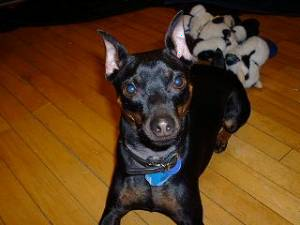

In [ ]:
show_img_xyz(img)[0]

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()